# HW03 Fine-tuning

I recommend to work in [Lightning studio](https://lightning.ai/simecek/studios/fastai-transfer-learning-fine-tuning~01hv3p406bs3pebc3xm2qwtwz1) (and not Colab), because of preinstalled environment and permanent disk space.

## Data preparation

 1. You need to upload your dataset to the virtual machine. Since the dataset is relatively small, it's easiest to ZIP the data and use the 'Upload Files' button in the top left corner.
 2. You can unzip the data either through the Terminal or directly within the Jupyter Notebook using the command: `!unzip YOURFILENAME.zip`
 3. Optionally, organize the image files as shown in the schema below.

```
DATASET_NAME/
│
├── train/
│   ├── CATEGORY1/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── CATEGORY2/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── ...
│
└── test/
    ├── CATEGORY1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── CATEGORY2/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── ...
```

If the data are organized in this form, you can obtain dataloaders as below. Otherwise, adapt `ImageDataLoaders` / `DataBlocks` accordingly.


In [12]:
!unzip -o Data/Animals_Recognition.zip

Archive:  Data/Animals_Recognition.zip
  inflating: Animals_Recognition/deer_344.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_344.jpg  
  inflating: Animals_Recognition/deer_422.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_422.jpg  
  inflating: Animals_Recognition/deer_436.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_436.jpg  
  inflating: Animals_Recognition/deer_378.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_378.jpg  
  inflating: Animals_Recognition/deer_387.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_387.jpg  
  inflating: Animals_Recognition/rabbit_729.jpg  
  inflating: __MACOSX/Animals_Recognition/._rabbit_729.jpg  
  inflating: Animals_Recognition/deer_393.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_393.jpg  
  inflating: Animals_Recognition/rabbit_701.jpg  
  inflating: __MACOSX/Animals_Recognition/._rabbit_701.jpg  
  inflating: Animals_Recognition/rabbit_715.jpg  
  inflating: __MACOSX/Animals_Recognition/._rab

  inflating: __MACOSX/Animals_Recognition/._deer_423.jpg  
  inflating: Animals_Recognition/deer_353.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_353.jpg  
  inflating: Animals_Recognition/deer_421.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_421.jpg  
  inflating: Animals_Recognition/deer_347.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_347.jpg  
  inflating: Animals_Recognition/deer_390.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_390.jpg  
  inflating: Animals_Recognition/deer_384.jpg  
  inflating: __MACOSX/Animals_Recognition/._deer_384.jpg  
  inflating: Animals_Recognition/rabbit_716.jpg  
  inflating: __MACOSX/Animals_Recognition/._rabbit_716.jpg  
  inflating: Animals_Recognition/rabbit_702.jpg  
  inflating: __MACOSX/Animals_Recognition/._rabbit_702.jpg  
  inflating: Animals_Recognition/shark_48.jpg  
  inflating: __MACOSX/Animals_Recognition/._shark_48.jpg  
  inflating: Animals_Recognition/shark_60.jpg  
  inflating: __MACOSX/Animals

In [1]:
import os
import shutil
import random

In [13]:


# Define your source and target directories
source_folder = './Animals_Recognition'
train_folder = 'dataset/train'
test_folder = 'dataset/test'

# Define animals of interest
animals = ['deer', 'shark', 'dog', 'rabbit']

# Create Train and Test folders, and animal subfolders within each
for folder in [train_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)
    for animal in animals:
        os.makedirs(os.path.join(folder, animal), exist_ok=True)

# Get all image files in the source folder
all_images = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]

# Shuffle the images to randomize the split
random.shuffle(all_images)

# Determine the split index
split_index = int(len(all_images) * 0.8)

# Split into train and test sets
train_images = all_images[:split_index]
test_images = all_images[split_index:]

# Function to move images based on their names
def move_images(images, target_folder):
    for image in images:
        # Check if the image name starts with any of the animal names
        for animal in animals:
            if image.startswith(animal):
                # Move the image to the corresponding subfolder
                shutil.move(os.path.join(source_folder, image), os.path.join(target_folder, animal, image))
                break  # Exit loop after finding the correct category

# Move images to Train and Test folders
move_images(train_images, train_folder)
move_images(test_images, test_folder)

print("Images successfully organized into Train and Test folders.")

Images successfully organized into Train and Test folders.


In [2]:
from fastai.vision.all import *
from pathlib import Path

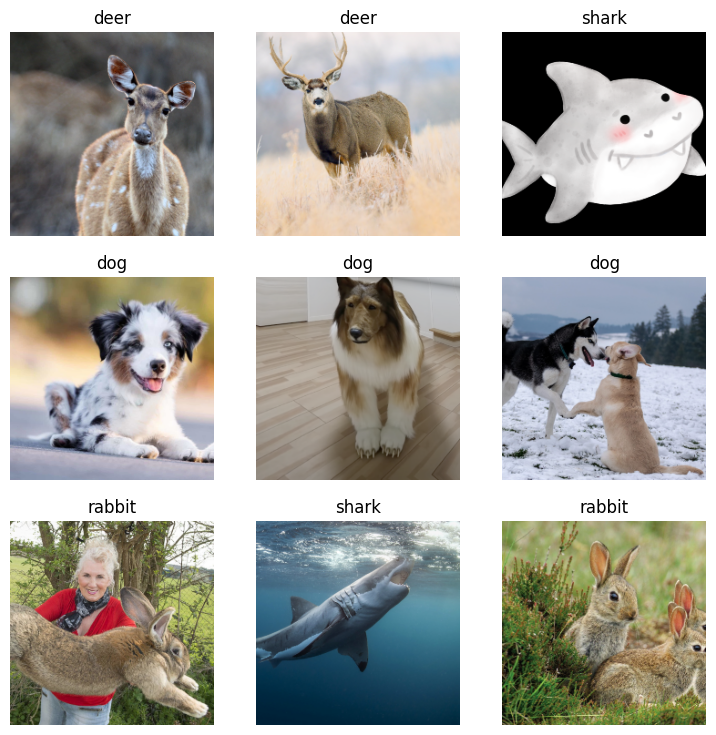

In [3]:
path = Path('dataset') / 'train'

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the train folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(460),# Resize the images to 460x460 (or your desired size)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
    bs=64                 # Batch size 64
)

dls.show_batch(max_n=9)

In [4]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

## Train the model

  1. Choose a pretrained model.
  2. Determine the optimal learning rate using the learning rate finder.
  3. Fine-tune the pretrained model to adapt it to your dataset.

Regarding the model, use rather [something smaller](https://www.kaggle.com/code/jhoward/which-image-models-are-best) from `timm` package. Architectures like convexnet, resnet, vgg or mobilenet should be fine.

In [5]:
from timm import list_models

In [6]:
# list_models(pretrained=True)
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.0014454397605732083)

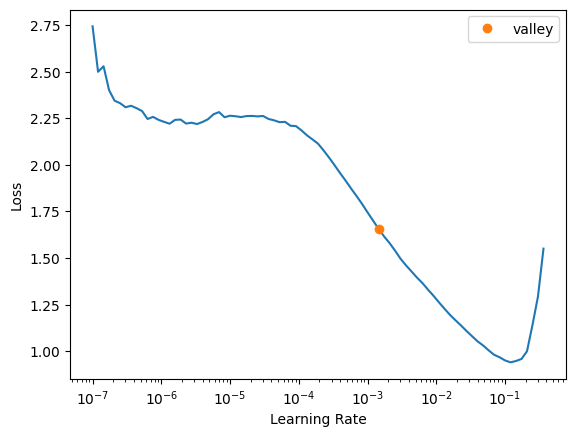

In [7]:
learn.lr_find()

In [8]:
lr =  0.0014454397605732083
epochs =  5

In [9]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.853111,0.194276,0.075000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.461520,0.142024,0.050000,00:08
1,0.369374,0.121222,0.058333,00:08
2,0.290095,0.104625,0.041667,00:08
3,0.232290,0.088116,0.033333,00:08
4,0.194364,0.088951,0.033333,00:08


Evaluate the model's performance...

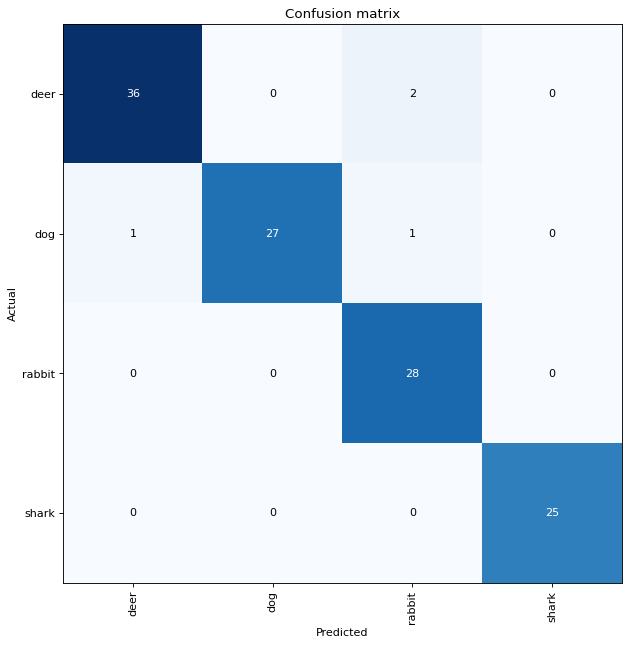

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

...and see the misclassified images in the validation set.

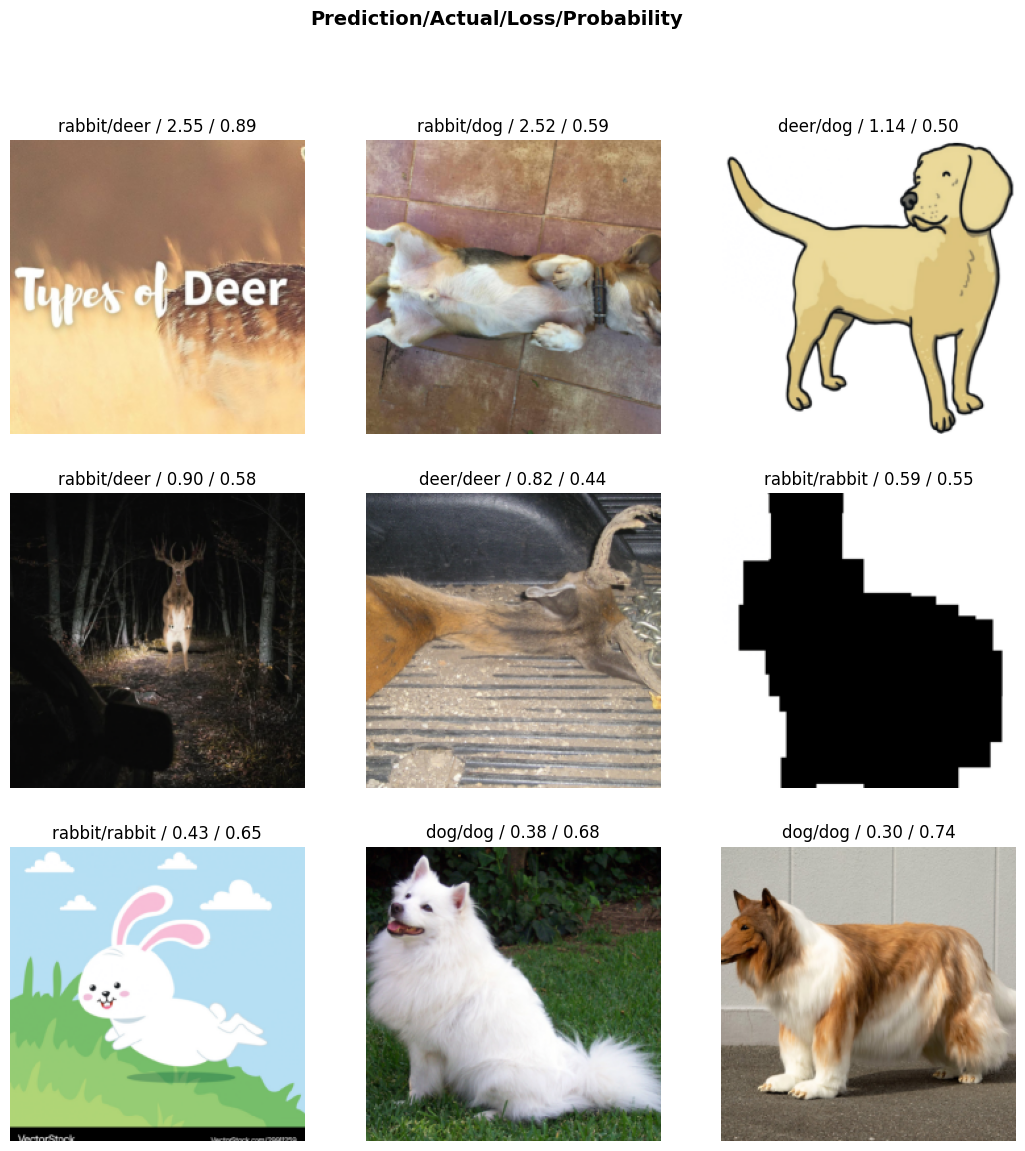

In [11]:
interp.plot_top_losses(9, figsize=(13,13))

If you see a mess, you might want to clean your data - there is a widget for that! It will list the most suspicios images (=highest loss) per set (train/valid) and category. Mark these images for deletion...

In [12]:
from fastai.vision.widgets import *

# cleaner = ImageClassifierCleaner(learn)
# cleaner

...and now actually delete them.

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

10


After deleting the images, you need to rerun the entire notebook from the first cell to update the dataloaders, as they will point to deleted files.

## Test the model on a test set

In [14]:
# Create a test DataLoader
test_path = Path('dataset') / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [15]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [16]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]

In [17]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))

Test error rate:
0.07878787878787874


## Let us save the model

In [19]:
learn.export('/teamspace/studios/this_studio/model/model.pkl')

Make sure to **download** `model.pkl` to your laptop, as you will need it later.